In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization] dlt

# dlt plugin for Hamilton [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/dlt/dlt_plugin.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/dlt/dlt_plugin.ipynb)

This notebook shows how to use Hamilton [materializers](https://hamilton.dagworks.io/en/latest/concepts/materialization/) to move data between Hamilton and dlt.

Content:
1. Defining an illustrative Hamilton dataflow
2. `DataSaver`: save Hamilton results to a [dlt Destination](https://dlthub.com/docs/dlt-ecosystem/destinations/)
3. `DataLoader`: load data from a [dlt Resource](https://dlthub.com/docs/dlt-ecosystem/verified-sources/) (a single table from a Source) into a Hamilton node

In [1]:
%load_ext hamilton.plugins.jupyter_magic

import dlt
from hamilton import driver
from hamilton.io.materialization import to, from_
from hamilton.plugins import dlt_extensions

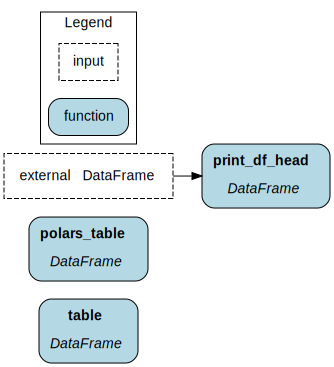

In [2]:
%%cell_to_module -m my_module -d
import pandas as pd
import polars as pl

def table() -> pd.DataFrame:
    return pd.DataFrame([{"C": 1}, {"C": 2}])

def polars_table() -> pl.DataFrame:
    return pl.DataFrame([{"C": 1}, {"C": 2}])

def print_df_head(external: pd.DataFrame) -> pd.DataFrame:
    print("from print_df_head:\n", external.head())

In [3]:
dr = driver.Builder().with_modules(my_module).build()

## DataSaver
With "Extract, Transform, Load" (ETL) as frame of reference, here, the Hamilton dataflow is responsible for Transform, and `DltDestination` for Load.


Start by defining a dlt `Pipeline` that uses your chosen dlt Destination. This is regular dlt code that you will pass to Hamilton.

In [4]:
saver_pipeline = dlt.pipeline(pipeline_name="saver_pipe", destination="duckdb")

### Single dependency
Define the materializer with `to.dlt()` the example below shows required arguments. You specify an `id` for the materializer and `dependencies` includes the name of a single Hamilton node. Then, specify a `table_name` for the destination and pass the `pipeline`. 

The [other keyword arguments](https://dlthub.com/docs/api_reference/pipeline/__init__#run) for `dlt.pipeline.run()` are accepted and allow specifying incremental loading, table schema annotation, and more.

{'dlt_metadata': {'pipeline': {'pipeline_name': 'saver_pipe'}, 'metrics': [{'started_at': DateTime(2024, 4, 17, 20, 22, 7, 283298, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 4, 17, 20, 22, 7, 453053, tzinfo=Timezone('UTC')), 'load_id': '1713385326.9071813'}], 'destination_type': 'dlt.destinations.duckdb', 'destination_displayable_credentials': 'duckdb:////home/tjean/projects/dagworks/hamilton/examples/dlt/saver_pipe.duckdb', 'destination_name': 'duckdb', 'environment': None, 'staging_type': None, 'staging_name': None, 'staging_displayable_credentials': None, 'destination_fingerprint': '', 'dataset_name': 'saver_pipe_dataset', 'loads_ids': ['1713385326.9071813'], 'load_packages': [{'load_id': '1713385326.9071813', 'package_path': '/home/tjean/.dlt/pipelines/saver_pipe/load/loaded/1713385326.9071813', 'state': 'loaded', 'completed_at': DateTime(2024, 4, 17, 20, 22, 7, 435481, tzinfo=Timezone('UTC')), 'jobs': [{'state': 'completed_jobs', 'file_path': '/home/tjean/.dlt/pipeline

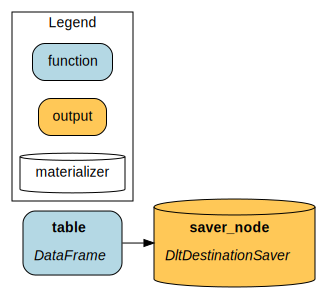

In [5]:
materializers = [
    to.dlt(
        id="saver_node",
        dependencies=["table"],
        table_name="my_table",
        pipeline=saver_pipeline,
    )
]
results, _ = dr.materialize(*materializers)
print(results["saver_node"])
dr.visualize_materialization(*materializers)

### Alternative dataframe libraries
By default, dlt only supports Python `Iterable` of records (e.g., JSON objects), pandas (`pd.DataFrame`) and pyarrow (`pyarrow.Table`, `pyarrow.BatchedRecords`). To save a polars, dask, vaex, velox, or duckdb object, you would need to convert it to a supported type first.

Hamilton provides adapter to make the process easy! Simply add the adapter to the `combine=` keyword of the data saver.

{'dlt_metadata': {'pipeline': {'pipeline_name': 'saver_pipe'}, 'metrics': [{'started_at': DateTime(2024, 4, 17, 20, 22, 24, 280884, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 4, 17, 20, 22, 24, 447750, tzinfo=Timezone('UTC')), 'load_id': '1713385343.9070144'}], 'destination_type': 'dlt.destinations.duckdb', 'destination_displayable_credentials': 'duckdb:////home/tjean/projects/dagworks/hamilton/examples/dlt/saver_pipe.duckdb', 'destination_name': 'duckdb', 'environment': None, 'staging_type': None, 'staging_name': None, 'staging_displayable_credentials': None, 'destination_fingerprint': '', 'dataset_name': 'saver_pipe_dataset', 'loads_ids': ['1713385343.9070144'], 'load_packages': [{'load_id': '1713385343.9070144', 'package_path': '/home/tjean/.dlt/pipelines/saver_pipe/load/loaded/1713385343.9070144', 'state': 'loaded', 'completed_at': DateTime(2024, 4, 17, 20, 22, 24, 425481, tzinfo=Timezone('UTC')), 'jobs': [{'state': 'completed_jobs', 'file_path': '/home/tjean/.dlt/pipel

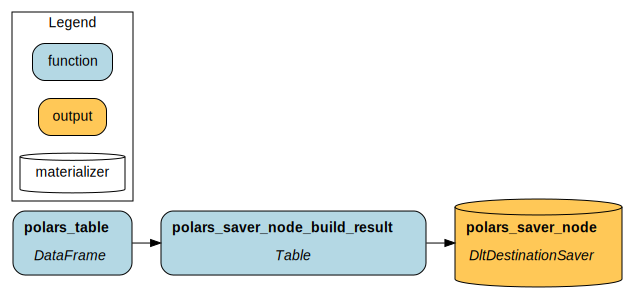

In [7]:
from hamilton.plugins import h_pyarrow

materializers = [
    to.dlt(
        id="polars_saver_node",
        dependencies=["polars_table"],
        combine=h_pyarrow.PyarrowTableResult(),
        table_name="my_polars_table",
        pipeline=saver_pipeline,
    )
]
results, _ = dr.materialize(*materializers)
print(results["polars_saver_node"])
dr.visualize_materialization(*materializers)

## DataLoader
With ETL as a frame of reference, the `DataLoader` uses dlt to run the "Extract" step for the passed dlt `Resource`. 

Internally, it creates a temporary dlt Pipeline to run the extract and normalize steps then reads the files in-memory. The dlt Pipeline is then deleted. 

In [8]:
# this is a mock dlt Source for demo purposes
@dlt.source
def mock_source():
    iterable_data = [{"col": 1}, {"col": 2}, {"col": 3}] * 100
    
    @dlt.resource
    def mock_resource():
        yield from iterable_data
        
    yield mock_resource
        
my_mock_source = mock_source()

### Single resource
To define the materializer, give it a `target` Hamilton node and pass a dlt Resource to `resource`. When working with a dlt Source, you can access individual resources via the dictionary `Source.resource[RESOURCE_NAME]`

In [9]:
materializers = [
    from_.dlt(
        target="external",
        resource=my_mock_source.resources["mock_resource"],
    ),
]

metadata, _ = dr.materialize(
    *materializers,
    additional_vars=["print_df_head"]
)

from print_df_head:
    col        _dlt_load_id         _dlt_id
0    1  1713385353.1057432  nV52FbDDaG8Hng
1    2  1713385353.1057432  1PnuRBfd/pFmbg
2    3  1713385353.1057432  E29IvCLX2o0hBw
3    1  1713385353.1057432  PHnW5pOvp3WRmA
4    2  1713385353.1057432  oRTCJeKpMP2OCQ
